In [1]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys

from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [29]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757
2023-12-12,-0.022229,0.000398,0.016043,-0.020613,0.000000,-0.014571,-0.075673,0.031381,0.039915,-0.017824,...,-0.035456,0.006897,0.029774,-0.023193,0.005521,-0.004283,0.003551,-0.005841,-0.006303,-0.020754
2023-12-13,0.003468,0.005173,0.000000,0.013739,0.000000,0.010562,0.007184,-0.002028,-0.011941,-0.009217,...,0.010886,-0.000685,0.001542,-0.000414,-0.019608,-0.005366,-0.004246,-0.005774,0.005120,0.004627


In [30]:
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)

In [92]:
timestamps = []  # Store timestamps for each window
mats = []
corr_mats = []
sharpe_r = []

for t_idx in range(0, len(returns) - 252):
    start_date = returns.index[t_idx+252] 
    period_returns = returns.iloc[t_idx:(t_idx + 252)].fillna(0)
    period_market_cap = market_cap.iloc[t_idx:(t_idx + 252)].fillna(0)

    # Randomly select 60 stocks, assuming there are at least 60
    if len(period_returns.columns) >= 60:
        # Select top 60 stocks based on market capitalization
        avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
        top_60_stocks = avg_market_cap.head(60).index
        period_returns = period_returns[top_60_stocks]
    else:
        #print("Not enough columns to select 60 stocks. Skipping this iteration.")
        continue

    # Fill NaNs with 0
    period_returns = period_returns.fillna(0)

    # Calculate correlation
    corr_mat = period_returns.corr().fillna(0).values
    
    # Sharpe values
    mean_return = period_returns.mean(axis=1).mean() * 252
    vol = period_returns.mean(axis=1).std() * np.sqrt(252)
    sharpe = mean_return / vol
    
    # Flatten corr
    corr = corr_mat.flatten()
    
    # Order corr
    dist = np.sqrt(2 * (1 - corr_mat))
    #print(dist)
    Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
    prows = corr_mat[permutation, :]
    ordered_corr = prows[:, permutation]

    mats.append(corr)
    corr_mats.append(ordered_corr)
    timestamps.append(start_date)
    sharpe_r.append(sharpe)


In [70]:
# Convert list of flattened matrices into a 2D array for easier manipulation
corr_matrix_array = np.array(mats)

# Calculate meta-correlation matrix
meta_corr_matrix = np.corrcoef(corr_matrix_array)

# Ensure no NaN values - replace them with 0
# This step might be necessary if there are any NaN values resulting from the computation
meta_corr_matrix = np.nan_to_num(meta_corr_matrix)


In [71]:
# Apply PCA on the meta-correlation matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

pca = PCA()
pca_result = pca.fit_transform(meta_corr_matrix)
explained_variance = pca.explained_variance_ratio_

# Select number of components based on explained variance
n_components = np.argmax(explained_variance.cumsum() >= 0.92) + 1  # Adjust based on your variance requirement
pca_result_reduced = pca_result[:, :n_components]


In [55]:
pca_result_reduced

array([[-4.28270694, -1.44845198, -1.18637525, ..., -0.13875717,
        -0.52208842, -0.52157089],
       [-4.21814189, -1.50614627, -1.18873272, ..., -0.1247427 ,
        -0.55350021, -0.61727299],
       [-4.26429041, -1.44115023, -1.18713563, ..., -0.11022042,
        -0.56412243, -0.62420866],
       ...,
       [ 8.0027412 , -2.92208041, -0.58360926, ...,  0.01259539,
         1.10084115, -0.19132754],
       [ 7.96994684, -2.94043167, -0.59139972, ...,  0.00864616,
         1.10209847, -0.19315658],
       [ 7.9060531 , -2.92795124, -0.58913491, ...,  0.02003205,
         1.09323279, -0.19443101]])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

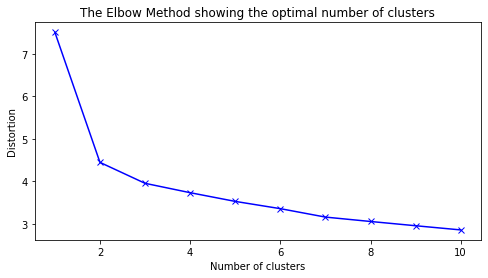

In [72]:
# Determine optimal number of clusters using the Elbow Method
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++')
    kmeanModel.fit(pca_result_reduced)
    distortions.append(sum(np.min(cdist(pca_result_reduced, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_result_reduced.shape[0])

# Plot the elbow plot to find the optimal k
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.savefig('elbow.png', bbox_inches='tight')
plt.show()




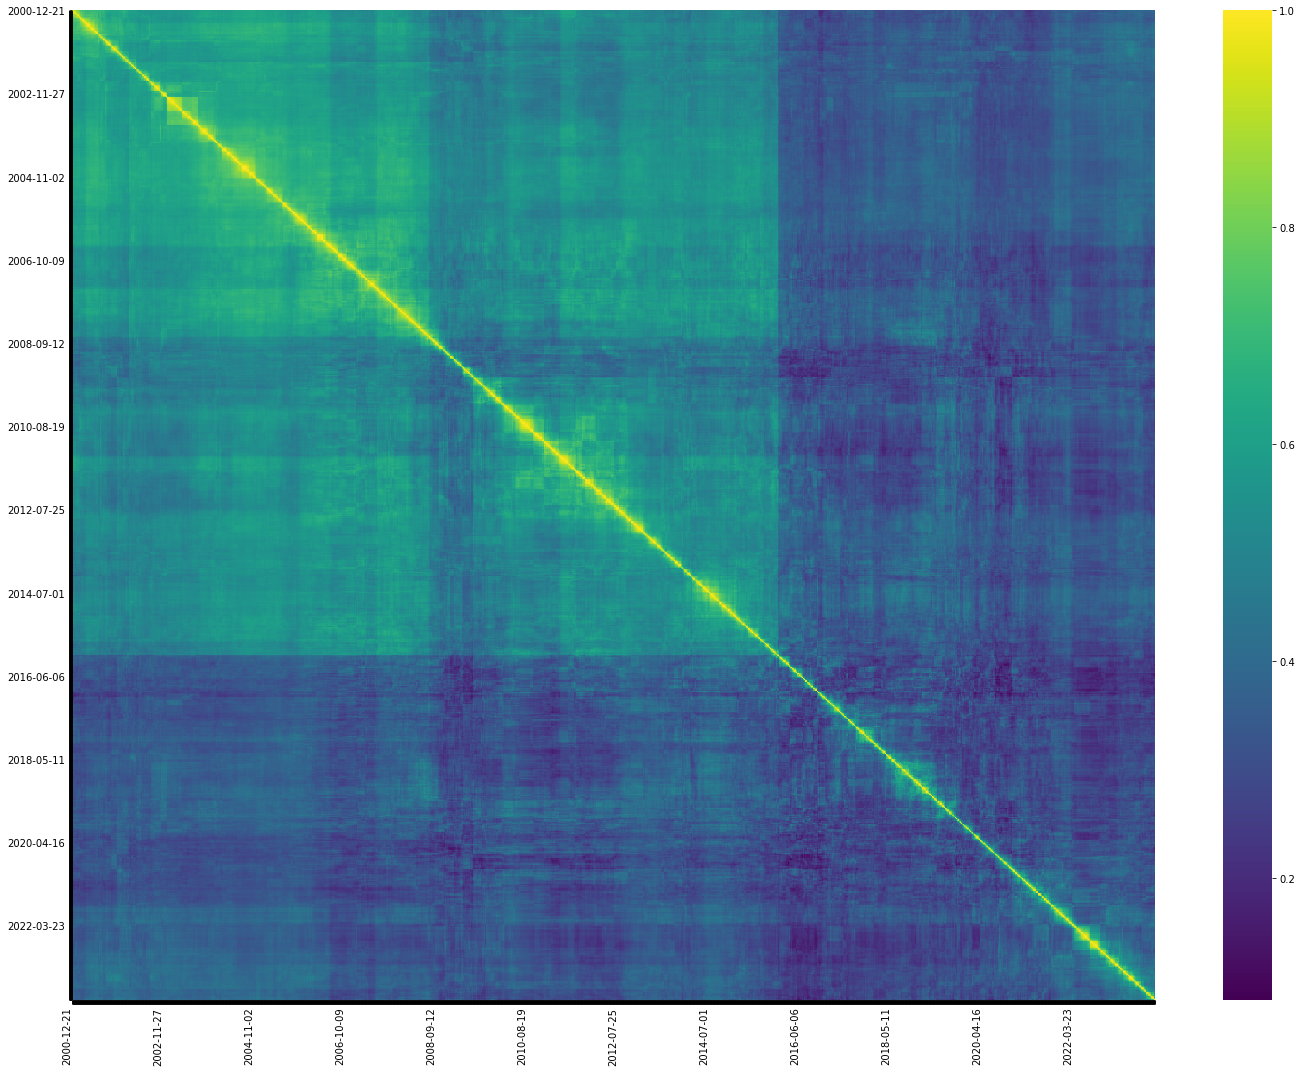

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert timestamps to pandas datetime if not already
timestamps = pd.to_datetime(timestamps)

# Create a mask for labels: Show the label for every 2 years
label_mask = [date.strftime("%Y-%m-%d") if i % (2 * 252) == 0 else '' for i, date in enumerate(timestamps)]

# Create a pandas DataFrame for the meta correlation matrix to label axes
meta_corr_df = pd.DataFrame(meta_corr_matrix, index=label_mask, columns=label_mask)

# Plotting
plt.figure(figsize=(20, 15))
sns.heatmap(meta_corr_df, annot=False, cmap='viridis', xticklabels=label_mask, yticklabels=label_mask)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('metacorrelation.png', bbox_inches='tight')
plt.show()


In [86]:
# Fit KMeans with the optimal number of clusters
# Based on the elbow plot, the optimal number of clusters (k_opt)
k_opt = 6
kmeans_optimal = KMeans(n_clusters=k_opt, init='k-means++')
kmeans_optimal.fit(pca_result_reduced)
cluster_labels = kmeans_optimal.labels_


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


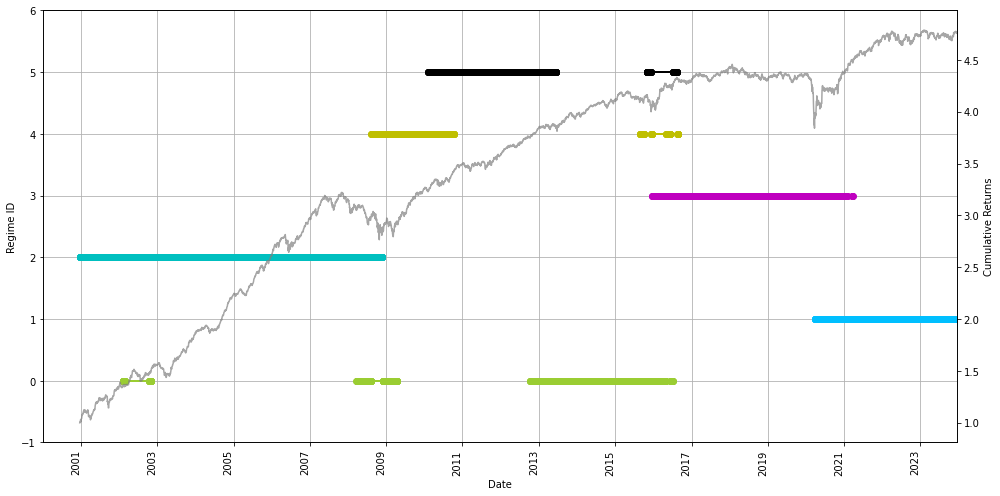

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate cumulative returns
cumulative_returns = returns.loc[timestamps[0]:].mean(axis=1).cumsum()+1

aligned_dates = returns.index[returns.index >= timestamps[0]]

# Colors for clusters - adjust if more clusters
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']

# Create the main figure and axis for regimes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the regimes as horizontal lines on the left y-axis
for i, (start, label) in enumerate(zip(timestamps, cluster_labels)):
    end = start + pd.DateOffset(days=251)
    # Draw a line segment for each regime
    ax1.plot([start, end], [label, label], color=colors[label], marker='o', linestyle='-', linewidth=2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Regime ID')
ax1.set_ylim(-1, max(cluster_labels) + 1)  # Extend the y-axis limits to show all regime IDs
ax1.set_xlim(returns.index.min(), returns.index.max())  # Set the x-axis limits to fit the dates

# Create the second y-axis for cumulative returns
ax2 = ax1.twinx()
ax2.plot(aligned_dates, cumulative_returns, color='grey', alpha=0.7)
ax2.set_ylabel('Cumulative Returns')

# Set the x-axis to only display labels every two years
years = pd.date_range(start=returns.index.min(), end=returns.index.max(), freq='2YS')
ax1.set_xticks(years)
ax1.set_xticklabels([year.strftime('%Y') for year in years], rotation=90, ha="right")

# Set grid and title
ax1.grid(True)
ax2.grid(False)
plt.tight_layout()
plt.savefig('regime_plot.png', bbox_inches='tight')
plt.show()

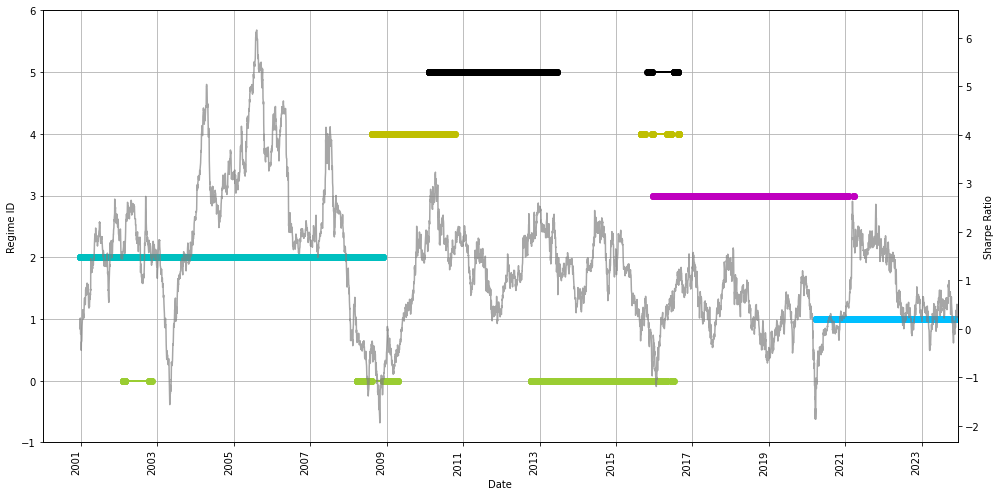

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Colors for clusters - adjust if more clusters
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']

# Create the main figure and axis for regimes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the regimes as horizontal lines on the left y-axis
for i, (start, label) in enumerate(zip(timestamps, cluster_labels)):
    end = start + pd.DateOffset(days=251)
    # Draw a line segment for each regime
    ax1.plot([start, end], [label, label], color=colors[label], marker='o', linestyle='-', linewidth=2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Regime ID')
ax1.set_ylim(-1, max(cluster_labels) + 1)  # Extend the y-axis limits to show all regime IDs
ax1.set_xlim(returns.index.min(), returns.index.max())  # Set the x-axis limits to fit the dates

# Create the second y-axis for cumulative returns
ax2 = ax1.twinx()
ax2.plot(aligned_dates, sharpe_r, color='grey', alpha=0.7)
ax2.set_ylabel('Sharpe Ratio')

# Set the x-axis to only display labels every two years
years = pd.date_range(start=returns.index.min(), end=returns.index.max(), freq='2YS')
ax1.set_xticks(years)
ax1.set_xticklabels([year.strftime('%Y') for year in years], rotation=90, ha="right")

# Set grid and title
ax1.grid(True)
ax2.grid(False)
plt.tight_layout()
plt.savefig('regime_plot.png', bbox_inches='tight')
plt.show()

In [96]:
# Create a new list to store the matrices along with next timeframe regime label
labeled_corr_mats = []

# Iterate through the matrices and labels, skipping the last one
for i in range(len(corr_mats) - 1):
    current_matrix = corr_mats[i]
    # The label for the "next day" is the label of the next matrix in the sequence
    label = cluster_labels[i + 1]
    date = timestamps[i]
    labeled_corr_mats.append((date, current_matrix, label))

In [97]:
labeled_corr_mats

[(Timestamp('2000-12-21 00:00:00'),
  array([[ 1.        ,  0.35614083,  0.32990461, ...,  0.05699485,
          -0.02601448,  0.12188385],
         [ 0.35614083,  1.        ,  0.43983952, ...,  0.0757268 ,
          -0.07982771, -0.02741597],
         [ 0.32990461,  0.43983952,  1.        , ...,  0.02200382,
          -0.0847104 , -0.12245667],
         ...,
         [ 0.05699485,  0.0757268 ,  0.02200382, ...,  1.        ,
           0.56156946,  0.45739453],
         [-0.02601448, -0.07982771, -0.0847104 , ...,  0.56156946,
           1.        ,  0.50034403],
         [ 0.12188385, -0.02741597, -0.12245667, ...,  0.45739453,
           0.50034403,  1.        ]]),
  2),
 (Timestamp('2000-12-22 00:00:00'),
  array([[ 1.        ,  0.35598437,  0.33011735, ...,  0.05092276,
          -0.02915114,  0.11897567],
         [ 0.35598437,  1.        ,  0.43978853, ...,  0.07459245,
          -0.0791083 , -0.027226  ],
         [ 0.33011735,  0.43978853,  1.        , ...,  0.01920179,
       

In [101]:
# Assuming 'labeled_corr_mats' is defined as before, and we have the dates to remove:
dates_to_remove = [pd.to_datetime('2007-12-31'), pd.to_datetime('2013-01-01')]

# Correctly filter out the specified dates using list comprehension
filtered_data = [(date, matrix, label) for (date, matrix, label), timestamp in zip(labeled_corr_mats, timestamps_pd) if timestamp not in dates_to_remove]

# Now that 'filtered_data' is correctly populated, continue with the split into training and test datasets
train_data = []
test_data = []

# Define the start and end of the test period
test_period_start = pd.to_datetime('2008-01-01')
test_period_end = pd.to_datetime('2012-12-31')

# Split the filtered data based on the date
for date, matrix, label in filtered_data:
    timestamp = pd.to_datetime(date)  # Ensuring 'date' is in datetime format for comparison
    if test_period_start <= timestamp <= test_period_end:
        test_data.append((date, matrix, label))
    else:
        train_data.append((date, matrix, label))

# 'train_data' now contains data outside the 2008-2012 range, excluding specific dates, and 'test_data' contains data within the 2008-2012 range.

# Sort the test_data based on date to ensure chronological order
test_data.sort(key=lambda x: x[0])

# Calculate the index to retain only the first 90% of the test data
cut_off_index = int(len(test_data) * 0.9)

# Keep only the first 90% of the test data
test_data = test_data[:cut_off_index]

# Randomly shuffle the training data
random.shuffle(train_data)


In [102]:
train_data

[(Timestamp('2006-05-10 00:00:00'),
  array([[1.        , 0.48178812, 0.48116156, ..., 0.10057242, 0.05337095,
          0.        ],
         [0.48178812, 1.        , 0.81302046, ..., 0.04633382, 0.06664095,
          0.        ],
         [0.48116156, 0.81302046, 1.        , ..., 0.01731083, 0.06112826,
          0.        ],
         ...,
         [0.10057242, 0.04633382, 0.01731083, ..., 1.        , 0.07176292,
          0.        ],
         [0.05337095, 0.06664095, 0.06112826, ..., 0.07176292, 1.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  2),
 (Timestamp('2015-05-15 00:00:00'),
  array([[ 1.        ,  0.44237134,  0.43941159, ...,  0.10195934,
           0.04432683, -0.02132968],
         [ 0.44237134,  1.        ,  0.6060065 , ...,  0.07064625,
           0.02314766,  0.06969672],
         [ 0.43941159,  0.6060065 ,  1.        , ...,  0.07607443,
           0.0344043 , -0.01064718],
      

In [110]:
import torch as th
import numpy as np
from torch.utils import data

# Assuming train_data and test_data are already defined
# Convert train_data and test_data from (date, matrix, label) to just (matrix, label)
train_matrices, train_labels = zip(*[(matrix, label) for _, matrix, label in train_data])
test_matrices, test_labels = zip(*[(matrix, label) for _, matrix, label in test_data])

class DatasetCorrMats(data.Dataset):
    def __init__(self, matrices, labels):
        self.matrices = np.array(matrices)
        self.labels = np.array(labels)

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        # Load the matrix and convert to torch tensor
#         x = th.from_numpy(self.matrices[idx]).double()
#         x = th.from_numpy(self.matrices[idx]).double().to(torch.float)  # Convert to float if necessary
        x = th.from_numpy(self.matrices[idx]).double()
        x = x[None, :, :].real  # Add a new dimension and take the real part
        
#         x = x.unsqueeze(0).real  # Add a new dimension for channel

        # Get the label and convert to long tensor
        y = th.tensor(self.labels[idx], dtype=th.long)

        return x, y

In [111]:
class CorrMatsNet(nn.Module):
    def __init__(self, bn=False):
        super(__class__, self).__init__()
        dim = 60
        dim1 = 20
        classes = 6
        self._bn = bn
        self.bimap1 = spdnet.BiMap(1, 1, dim, dim1)
        if bn:
            self.batchnorm1 = spdnet.BatchNormSPD(dim1)
        self.logeig = spdnet.LogEig()
        self.linear = nn.Linear(dim1**2, classes).double()
    def forward(self, x):
        x = self.bimap1(x)
        if self._bn:
            x = self.batchnorm1(x)
        x = self.logeig(x)
        x_vec = x.view(x.shape[0], -1)
        y = self.linear(x_vec)
        return y

In [117]:
def train_model(train_generator, test_generator, use_rbn=True,
                batch_size=30, lr=1e-2, threshold_reeig = 1e-4, epochs=600,
                n=60, C=6):

  model = CorrMatsNet(bn=use_rbn)

  loss_fn = nn.CrossEntropyLoss()
  opti = MixOptimizer(model.parameters(),lr=lr)

  #initial validation accuracy
  loss_val, acc_val = [], []
  y_true, y_pred = [], []
  model.eval()
  for local_batch, local_labels in test_generator:
      out = model(local_batch)
      l = loss_fn(out, local_labels)
      predicted_labels=out.argmax(1)
      y_true.extend(list(local_labels.cpu().numpy()))
      y_pred.extend(list(predicted_labels.cpu().numpy()))
      acc, loss = ((predicted_labels==local_labels)
                  .cpu()
                  .numpy()
                  .sum()/out.shape[0],
                  l.cpu().data.numpy())
      loss_val.append(loss)
      acc_val.append(acc)
  acc_val = np.asarray(acc_val).mean()
  loss_val = np.asarray(loss_val).mean()
  print('Initial validation accuracy: ' + str(round(100 * acc_val, 2)) + '%')
  spdnet_acc = []
  spdnet_acc.append(acc_val)

  #training loop
  for epoch in range(epochs):

      # train one epoch
      loss_train, acc_train = [], []
      total_train_batches = len(train_generator)
      model.train()
      for i, (local_batch, local_labels) in enumerate(train_generator, start=1):
          opti.zero_grad()
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          acc, loss = ((out.argmax(1) == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out.shape[0],
                      l.cpu().data.numpy())
          loss_train.append(loss)
          acc_train.append(acc)
#           print(f'Epoch {epoch+1}/{epochs}, Train Batch {i}/{total_train_batches}, Loss: {l.item():.4f}, Accuracy: {acc:.4f}')
          l.backward()
          opti.step()
      acc_train = np.asarray(acc_train).mean()
      loss_train = np.asarray(loss_train).mean()

      # validation
      acc_val_list = []
      loss_val_list = []
      y_true, y_pred = [], []
      total_val_batches = len(test_generator)
      model.eval()
      for i, (local_batch, local_labels) in enumerate(test_generator, start=1):
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          predicted_labels = out.argmax(1)
          y_true.extend(list(local_labels.cpu().numpy()))
          y_pred.extend(list(predicted_labels.cpu().numpy()))
          acc, loss = ((predicted_labels == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out
                      .shape[0], 
                      l.cpu().data.numpy())
          acc_val_list.append(acc)
          loss_val_list.append(loss)
#           print(f'Epoch {epoch+1}/{epochs}, Test Batch {i}/{total_val_batches}, Loss: {l.item():.4f}, Accuracy: {acc:.4f}')
      acc_val = np.asarray(acc_val_list).mean()
      loss_val = np.asarray(loss_val_list).mean()
      print(f'End of Epoch {epoch+1}/{epochs}, Validation Loss: {loss_val:.4f}, Validation Accuracy: {acc_val:.4f}')


#       if (epoch + 1) % 10 == 0:
#         print('Val acc: ' + str(round(100 * acc_val, 2)) + '% at epoch ' +
#               str(epoch + 1) + '/' + str(epochs))

      spdnet_acc.append(acc_val)

  return spdnet_acc, model

In [ ]:
acc_results = []
std_results = []
batch_size = 32
for use_rbn in [True, False]:
    # Calculate class cardinality
    for id_class in range(6):
        class_card = sum(1 for label in train_labels if label == id_class)
        print(f'Class {id_class} cardinal = {class_card}')

    # Create dataset instances
    train_set = DatasetCorrMats(train_matrices, train_labels)
    test_set = DatasetCorrMats(test_matrices, test_labels)

    # DataLoader instances
    train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    test_accuracy, model = train_model(train_generator, test_generator, use_rbn=use_rbn)

    acc_results.append(test_accuracy)
    
acc_results = np.array(acc_results)

Class 0 cardinal = 724
Class 1 cardinal = 952
Class 2 cardinal = 1813
Class 3 cardinal = 1129
Class 4 cardinal = 38
Class 5 cardinal = 31
Initial validation accuracy: 29.35%
End of Epoch 1/600, Validation Loss: 2.1409, Validation Accuracy: 0.0481
End of Epoch 2/600, Validation Loss: 2.3318, Validation Accuracy: 0.0481
End of Epoch 3/600, Validation Loss: 2.4174, Validation Accuracy: 0.0481
End of Epoch 4/600, Validation Loss: 2.4466, Validation Accuracy: 0.0481
End of Epoch 5/600, Validation Loss: 2.4685, Validation Accuracy: 0.0481
End of Epoch 6/600, Validation Loss: 2.4644, Validation Accuracy: 0.0481
End of Epoch 7/600, Validation Loss: 2.4508, Validation Accuracy: 0.0490


IndexError: index 2 is out of bounds for axis 0 with size 2

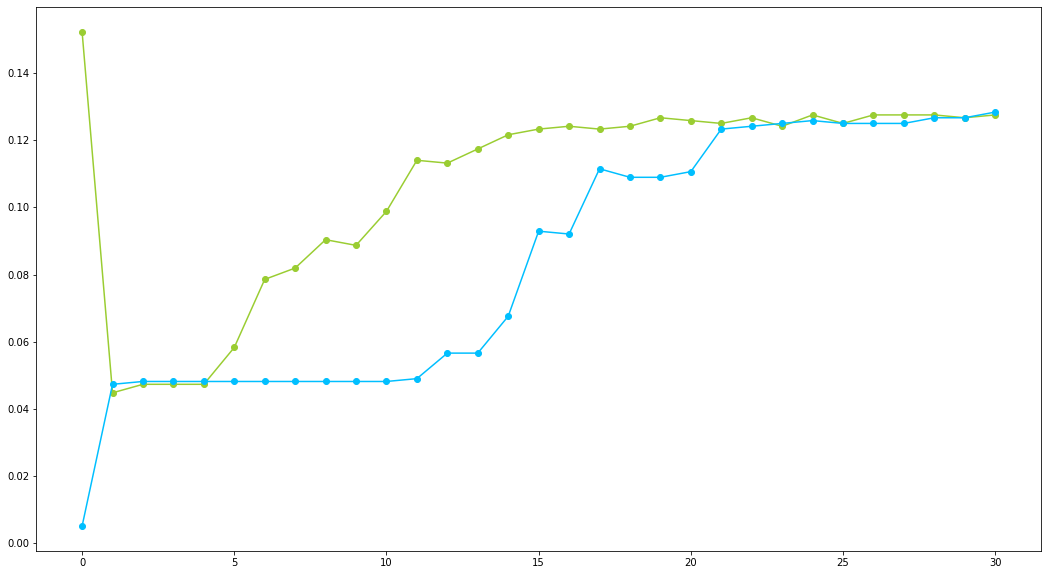

In [114]:
# Plotting
plt.figure(figsize=(18, 10))
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']
for i, train_size in enumerate(train_sizes):
    plt.plot(acc_results[i, :], '-o', color=colors[i % len(colors)],
             label=f'train sample size = {train_size} w/ RBN')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
#plt.title('Accuracy as a Function of Sample Size, Epochs, and use of Riemannian Batch-Normalisation', fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('accuracy_plot_top60_kmeans.png', bbox_inches='tight')
plt.show()